# Point(s) after Touchdown Decision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Point(s) after Touchdown as a Multi-Stage Decision

* Richard C. Porter, <a href=http://www.jstor.org/stable/2682653>Extra-Point Strategy in Football</a>. The American Statistician, Vol. 21, No. 5 (Dec., 1967), pp. 14-15.

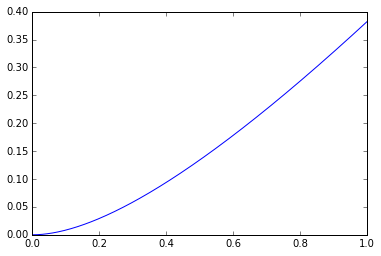

In [2]:
alpha = np.linspace(0,1,200)
beta = (2.0*alpha + 1 - np.sqrt(4.0*alpha + 1.0))/2.0

plt.plot(alpha, alpha/2.0)
plt.hold()
plt.plot(alpha,beta);

## Dynamic Programming Model

* Harold Sackrowitz, <a href="https://stat.duke.edu/~dalene/chance/chanceweb/133.sackrowitz.pdf">Refining the Point(s)-After-Touchdown Decision</a>.  Chance, Vol. 13, pp. 29-34, 2000.

In [31]:
# set parameters 
S = ['NS','FG','TD']
D = range(-100,100)
T = range(0,33)

# probabilities
p = dict() 
p['FG'] = 0.12   # possession results in field goal
p['TD'] = 0.20   # possession results in touchdown
p['XP'] = 0.98   # extra point kick is successful
p['2P'] = 0.41   # two point attempt is successful

p['NS'] = 1.0 - p['FG'] - p['TD']  # possession results in no score

In [32]:

idx = pd.MultiIndex.from_product([S,D,T],names = ['Score','Lead','Remaing Possessions'])

V = pd.Series(index=idx)
Vs = pd.Series(index=idx)

# initialize V and Vs for extreme values
for s,d,t in idx:
    if d < 0:
        V[s,d,t], Vs[s,d,t] = 0.0, 0.0
    elif d == 0:
        V[s,d,t], Vs[s,d,t] = 0.5, 0.5
    elif d > 0:
        V[s,d,t], Vs[s,d,t] = 1.0, 1.0

P1 = pd.Series(index=pd.MultiIndex.from_product([D,T]))
P2 = pd.Series(index=pd.MultiIndex.from_product([D,T]))
                                                                                                   

We'll assume the game ends on the opponents last possession. The possession can end with no score, a field goal, or touchdown.  Vs[s,d,0] is probability of a win after the opponent's possession ends with outcome s, out lead is d, but before the opponent's decision regarding the point after play.  We assume the opponent will always go for a tie and OT if given the choice.

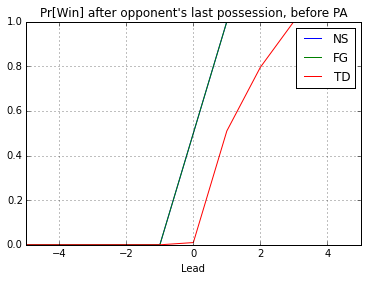

In [33]:
# for a lead of zero, only win OT after opp missed XP
Vs['TD',0,0] = (1.0 - p['XP'])/2.0

# for a lead of one, win in OT after opp ties with successful XP
Vs['TD',1,0] = 1.0 - p['XP']/2.0

# for a lead of two, win it OT after opp ties with successful two point conversion
Vs['TD',2,0] = 1.0 - p['2P']/2.0
      
# visualization
plt.hold(True)
Vs['NS',:,0].plot()
Vs['FG',:,0].plot()
Vs['TD',:,0].plot()
plt.hold(False)
plt.xlim(-5,5)
plt.legend(S)
plt.title("Pr[Win] after opponent's last possession, before PA")
plt.xlabel('Lead')
plt.grid()

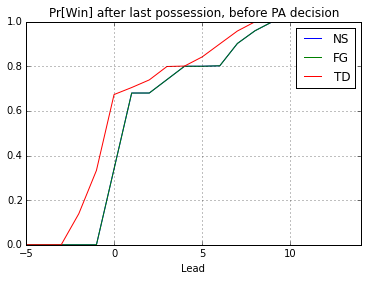

In [34]:
for d in D[6:-6]:
    
    # probability of winning with 0, 1, 2 extra points followed by opponent outcome
    q0 = p['NS']*Vs['NS',d+0,0] + p['FG']*Vs['FG',d-3,0] + p['TD']*Vs['TD',d-6,0]
    q1 = p['NS']*Vs['NS',d+1,0] + p['FG']*Vs['FG',d-2,0] + p['TD']*Vs['TD',d-5,0]
    q2 = p['NS']*Vs['NS',d+2,0] + p['FG']*Vs['FG',d-1,0] + p['TD']*Vs['TD',d-4,0]
    
    V['NS',d,0] = q0
    V['FG',d,0] = q0
            
    a = p['XP']*q1 + (1-p['XP'])*q0         
    b = p['2P']*q2 + (1-p['2P'])*q0
                 
    V['TD',d,0] = max(a,b)
    
    P1[d,0] = a
    P2[d,0] = b
                 
    Y[d,0] = (b-a)
    if b > a:
        X[d,0] = 2
    else:
        X[d,0] = 1
        
plt.hold(True)
V['NS',:,0].plot()
V['FG',:,0].plot()
V['TD',:,0].plot()
plt.hold(False)
plt.xlim(-5,14)
plt.legend(S)
plt.title('Pr[Win] after last possession, before PA decision')
plt.xlabel('Lead')
plt.grid()

In [35]:
for t in T[1:]:
    
    for d in D[6:-6]:
        q0 = p['NS']*V['NS',d+0,t-1] + p['FG']*V['FG',d+3,t-1] + p['TD']*V['TD',d+6,t-1]
        q1 = p['NS']*V['NS',d-1,t-1] + p['FG']*V['FG',d+2,t-1] + p['TD']*V['TD',d+5,t-1]
        q2 = p['NS']*V['NS',d-2,t-1] + p['FG']*V['FG',d+1,t-1] + p['TD']*V['TD',d+4,t-1]
        
        Vs['NS',d,t] = q0
        Vs['FG',d,t] = q0
        Vs['TD',d,t] = min(p['XP']*q1 + (1-p['XP'])*q0, p['2P']*q2 + (1-p['2P'])*q2)    
    
    for d in D[6:-6]:
        q0 = p['NS']*Vs['NS',d+0,t] + p['FG']*Vs['FG',d-3,t] + p['TD']*Vs['TD',d-6,t]
        q1 = p['NS']*Vs['NS',d+1,t] + p['FG']*Vs['FG',d-2,t] + p['TD']*Vs['TD',d-5,t]
        q2 = p['NS']*Vs['NS',d+2,t] + p['FG']*Vs['FG',d-1,t] + p['TD']*Vs['TD',d-4,t]
        
        V['NS',d,t] = q0
        V['FG',d,t] = q0
        P1[d,t] = (1-p['XP'])*q0 + p['XP']*q1
        P2[d,t] = (1-p['2P'])*q0 + p['2P']*q2
        V['TD',d,t] = max(P1[d,t],P2[d,t])

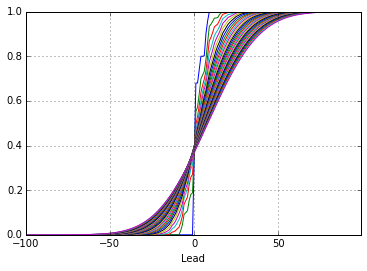

In [38]:
plt.hold(True)
for t in T:
    V['NS',:,t].plot()
plt.hold(False)
plt.grid()

In [12]:
print "      Possessions Remaining ->"
print "Lead"

print "    ",
for t in T:
    print "{0:3.0f} ".format(t),
print

for d in range(-20,21):
    print "{0:3.0f} ".format(d),
    for t in T:
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            if (P1[d,t] >= P2[d,t]):
                print "  . ",
            else:
                print "  2 ",
        else:
            print "    ",
    print

      Possessions Remaining ->
Lead
       0    1    2    3    4    5    6    7    8    9   10   11   12 
-20                   .    .    .    .    .    .    .    .    .    . 
-19                   2    2    2    2    2    .    .    .    .    . 
-18              2    2    .    .    .    .    .    .    .    .    . 
-17              2    .    .    .    .    .    .    .    .    .    . 
-16              2    2    2    2    2    .    .    .    .    .    . 
-15              2    2    2    .    .    .    .    .    .    .    . 
-14              .    .    .    .    .    .    .    .    .    .    . 
-13              2    2    2    .    .    .    .    .    .    .    . 
-12              .    .    .    .    .    .    .    .    .    .    . 
-11              .    .    .    .    .    .    .    .    .    .    . 
-10         2    2    2    .    .    .    .    .    .    .    .    . 
 -9         2    .    .    .    .    .    .    .    .    .    .    . 
 -8         2    2    2    2    2    2    .    .    . 

In [19]:
print "      Possessions Remaining ->"
print "Lead"

print "    ",
for t in T:
    print "{0:6.0f}".format(t),
print

for d in range(-20,21):
    print "{0:3.0f} ".format(d),
    for t in T:
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            print "{0:6.2f}".format(100.0*P1[d,t]),
        else:
            print "      ",
    print "\n    ",
    for t in T:
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            print "{0:6.2f}".format(100.0*P2[d,t]),
        else:
            print "      ",
    print "\n    ",
    for t in T:
        if (2 + 8*t + d >= 0) & (d <= 8*(t+1)) :
            print "{0:6.2f}".format(100.0*(P2[d,t]-P1[d,t])),
        else:
            print "      ",
    print "\n"

      Possessions Remaining ->
Lead
          0      1      2      3      4      5      6      7      8      9     10     11     12
-20                         0.22   0.66   1.23   1.89   2.60   3.31   4.00   4.67   5.31   5.90 
                            0.22   0.65   1.22   1.87   2.55   3.24   3.92   4.57   5.20   5.80 
                           -0.00  -0.00  -0.01  -0.02  -0.04  -0.07  -0.09  -0.10  -0.11  -0.11 

-19                         0.29   0.85   1.55   2.33   3.13   3.91   4.67   5.40   6.09   6.73 
                            0.31   0.88   1.58   2.35   3.14   3.91   4.65   5.36   6.02   6.65 
                            0.02   0.03   0.03   0.02   0.01  -0.01  -0.02  -0.05  -0.07  -0.09 

-18                  0.00   0.44   1.18   2.07   2.99   3.88   4.74   5.54   6.30   7.01   7.67 
                     0.04   0.47   1.17   2.01   2.91   3.80   4.65   5.46   6.21   6.92   7.58 
                     0.04   0.03  -0.02  -0.05  -0.08  -0.08  -0.09  -0.09  -0.09  -0.09  

## Analysis of Three Cases

### Northwestern at Notre Dame, 2014

### Notre Dame at Clemson, 2015

### Georgia Tech at Notre Dame, 2015